# Credit scoring model

In [156]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [157]:
from google.colab import files # Colab-specific library to load files
uploaded = files.upload() # Uploading file

# Confirming upload
for fn in uploaded.keys():
  print('You uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Reading the input

Saving hmeq.csv to hmeq (3).csv
You uploaded file "hmeq (3).csv" with length 403157 bytes


In [158]:
# Storing data in the form of Pandas dataframe

df=pd.read_csv("hmeq.csv")

In [159]:
# Displaying few rows to get a glimpse of the dataset

df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# 1. Understanding the data

In [160]:
df.shape

(5960, 13)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [162]:
# Descriptive stats, showing distribution of the data

df.describe()

# There are no anomalies in the data (we can say this by observing the maximums and means in each case)

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5442.000000,5848.000000,5445.000000,5252.000000,5380.000000,5652.000000,5450.000000,5738.000000,4693.000000
mean,0.199497,18607.969799,73760.817200,101776.048741,8.922268,0.254570,0.449442,179.766275,1.186055,21.296096,33.779915
std,0.399656,11207.480417,44457.609458,57385.775334,7.573982,0.846047,1.127266,85.810092,1.728675,10.138933,8.601746
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,46276.000000,66075.500000,3.000000,0.000000,0.000000,115.116702,0.000000,15.000000,29.140031
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262
75%,0.000000,23300.000000,91488.000000,119824.250000,13.000000,0.000000,0.000000,231.562278,2.000000,26.000000,39.003141
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [163]:
# Displaying column names of the dataset

df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'REASON', 'JOB', 'YOJ', 'DEROG',
       'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC'],
      dtype='object')

0    4771
1    1189
Name: BAD, dtype: int64


<Axes: >

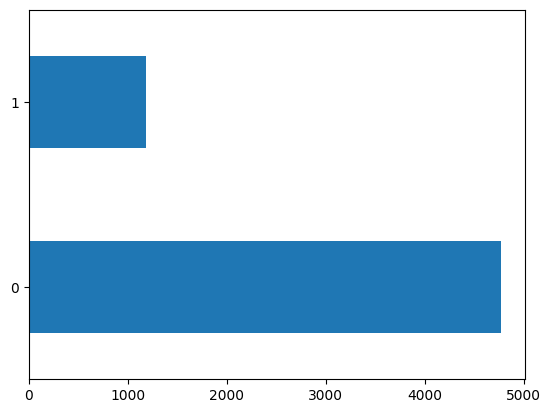

In [164]:
# Understanding the distribution of target variable "BAD"

print(df["BAD"].value_counts())
df["BAD"].value_counts().plot(kind="barh")

# The target class is a bit unbalanced - zeroes are about 80% and ones are about 20%,
# and this is also expected, as only a small fraction of customers are expected to be defaulters.

In [165]:
# This is a nominal feature. It must be modified in a way we can use it.

print(df["REASON"].value_counts())

DebtCon    3928
HomeImp    1780
Name: REASON, dtype: int64


In [166]:
# Same as the above case, we will find a way to use it.

print(df["JOB"].value_counts())

Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: JOB, dtype: int64


<Axes: ylabel='Frequency'>

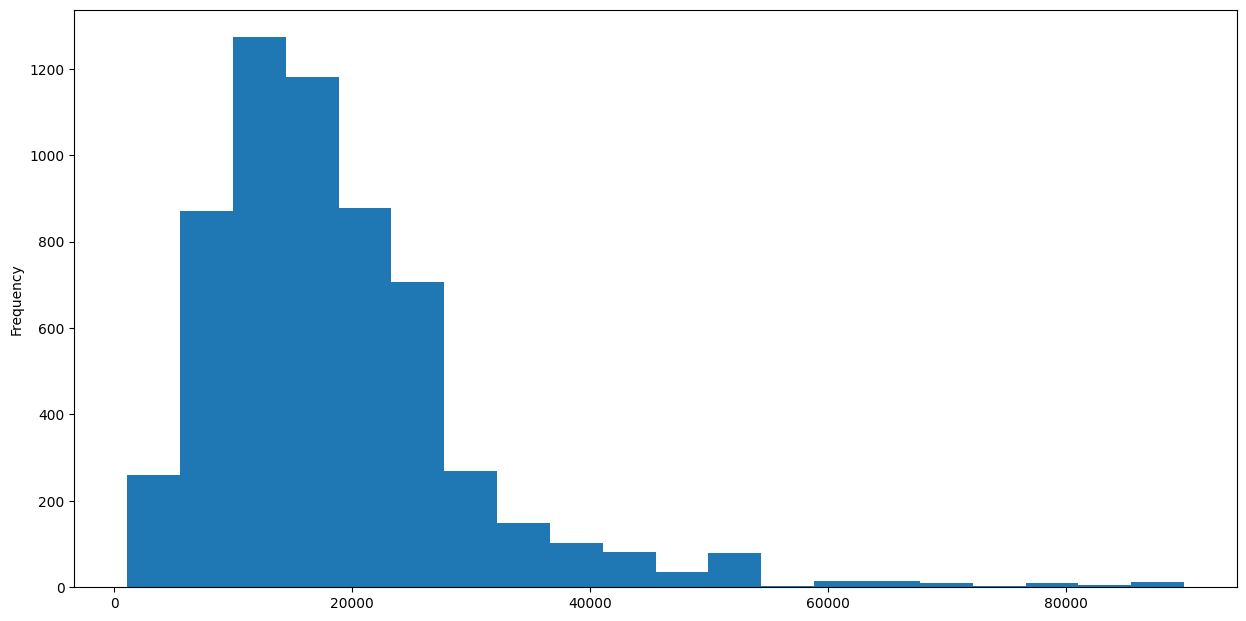

In [167]:
df["LOAN"].plot.hist(bins = 20,figsize=(15,7.5))

# We can see that distribution of loan variable density between 10000-30000 is high.

<Axes: ylabel='Frequency'>

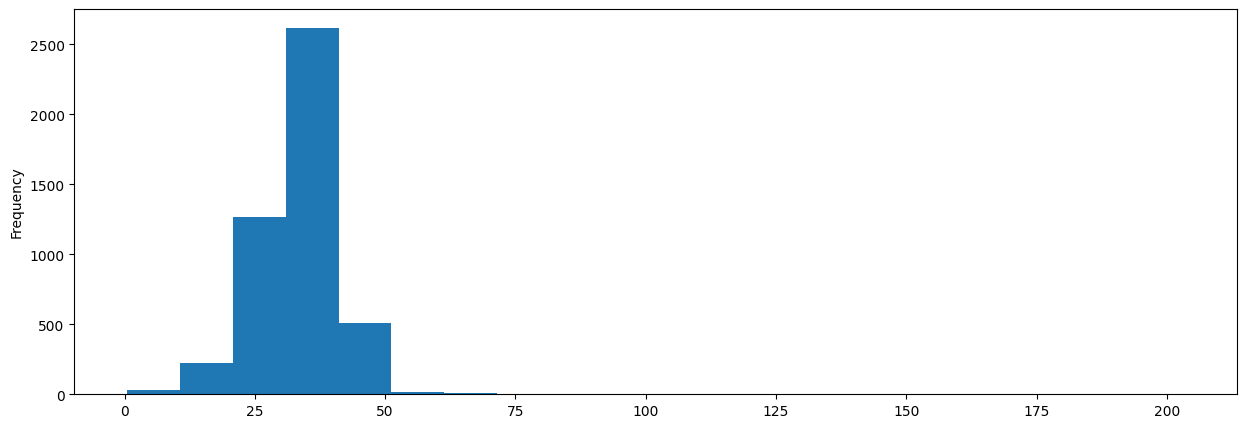

In [168]:
df["DEBTINC"].plot.hist(bins = 20,figsize=(15,5))

# Again, we notice that the histogram is highly populated around 25-50.
# We may cap off the end values if required, to simplify the statistics and reduce noise.
# However, in order to maintain model accuracy, we don't do this for any of the variables.

<Axes: ylabel='Frequency'>

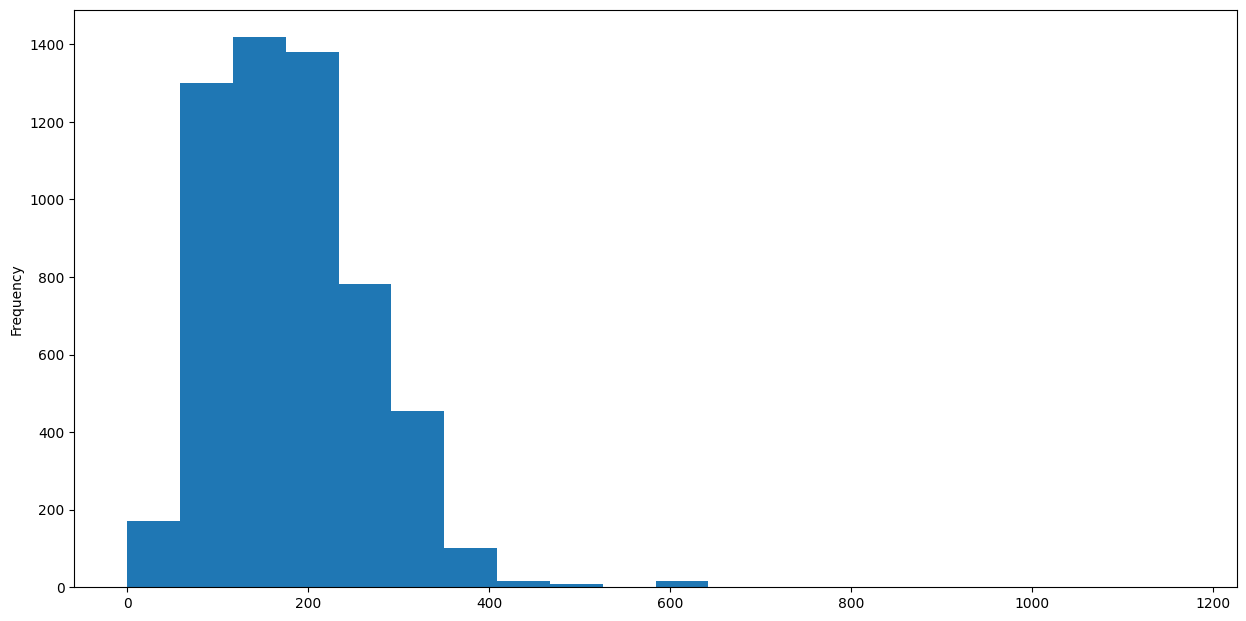

In [169]:
df["CLAGE"].plot.hist(bins = 20,figsize=(15,7.5))

# Here, the density is high around 100-300.
# We can cap off the values >= 600 to get better results.

<Axes: ylabel='Frequency'>

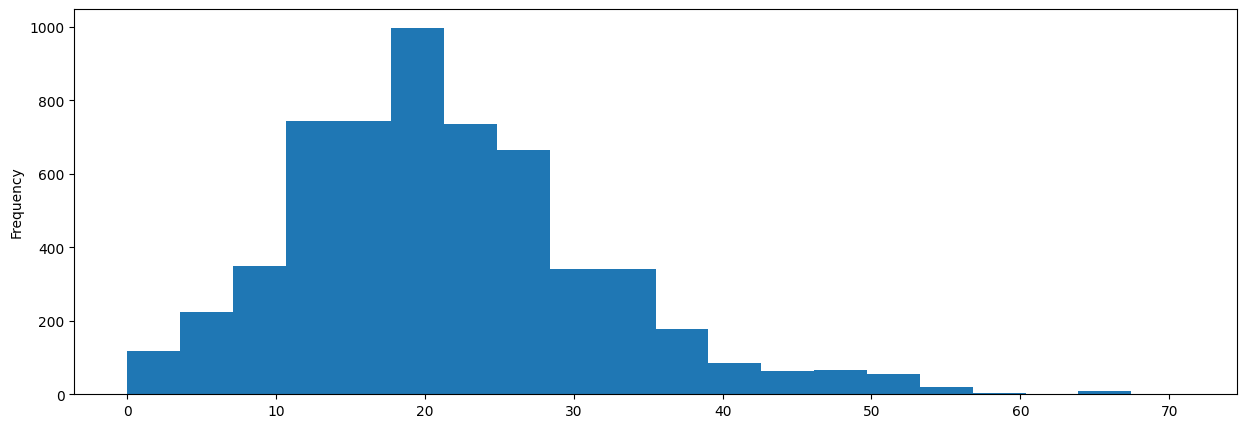

In [170]:
df["CLNO"].plot.hist(bins = 20,figsize=(15,5))

# This distribution looks good and we need not modify anything here.

<Axes: ylabel='Frequency'>

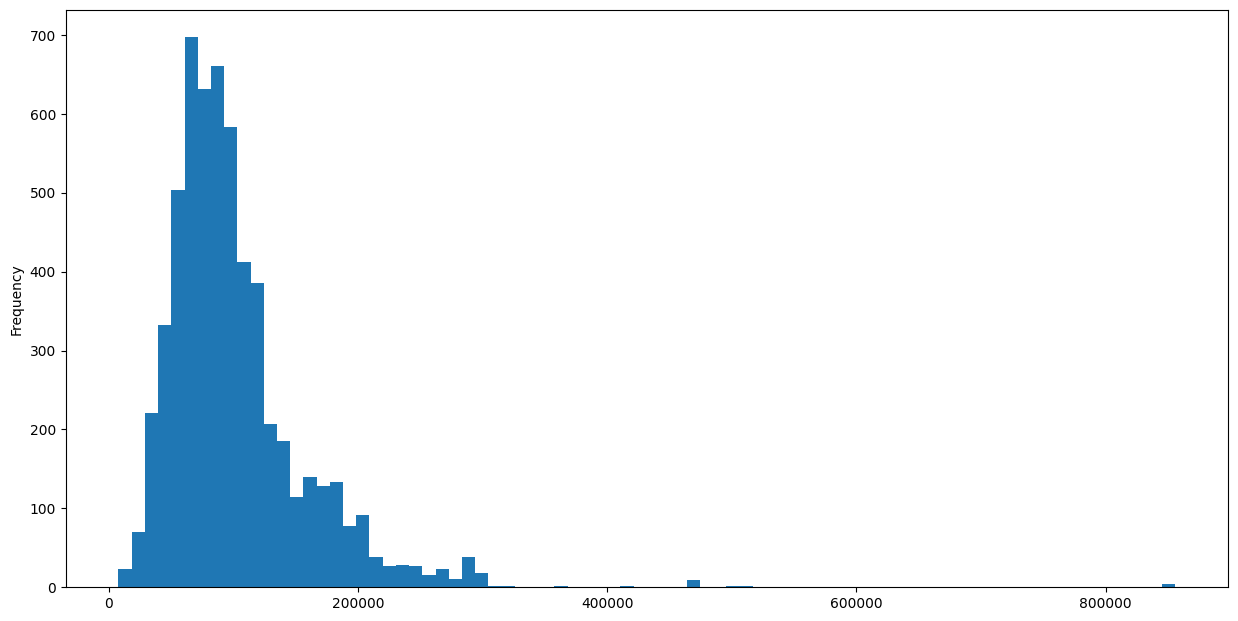

In [171]:
df["VALUE"].plot.hist(bins = 80,figsize=(15,7.5))

# Concentration is high around 80000-100000.
# There are very less values at the end(>= 400000) that are a bit high compared to mean. We can cap these off.

<Axes: ylabel='Frequency'>

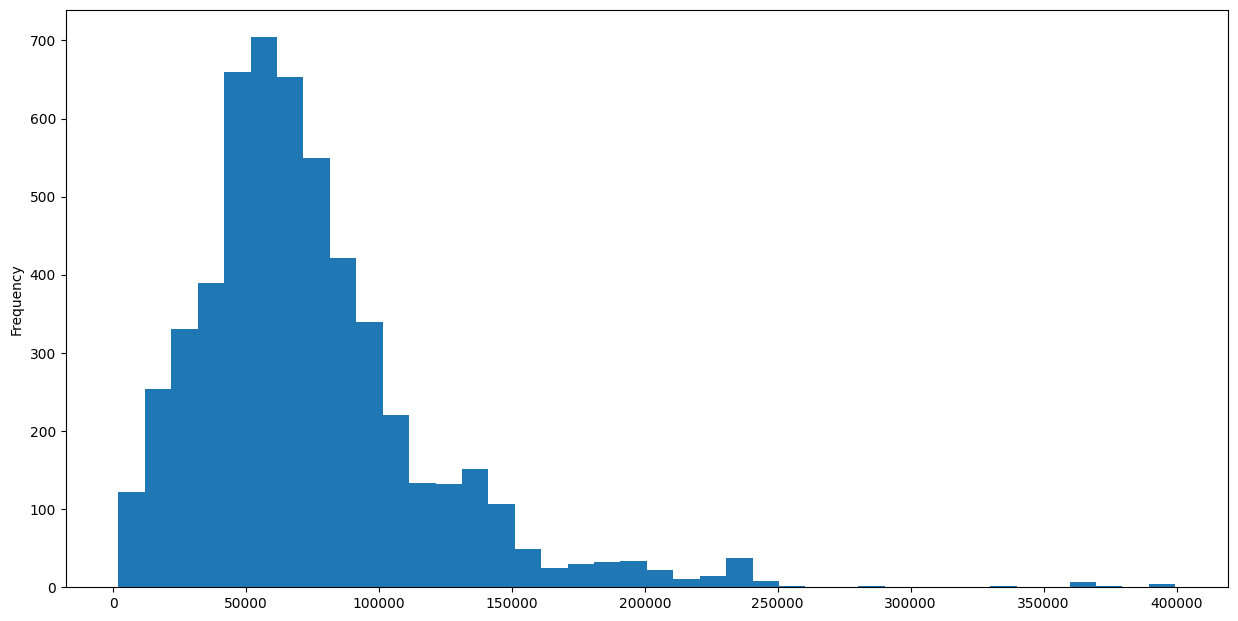

In [172]:
df["MORTDUE"].plot.hist(bins = 40,figsize=(15,7.5))

# Concentration is high around 40000-100000.
# The values at the end(>= 300000) can be capped off.

<Axes: ylabel='Frequency'>

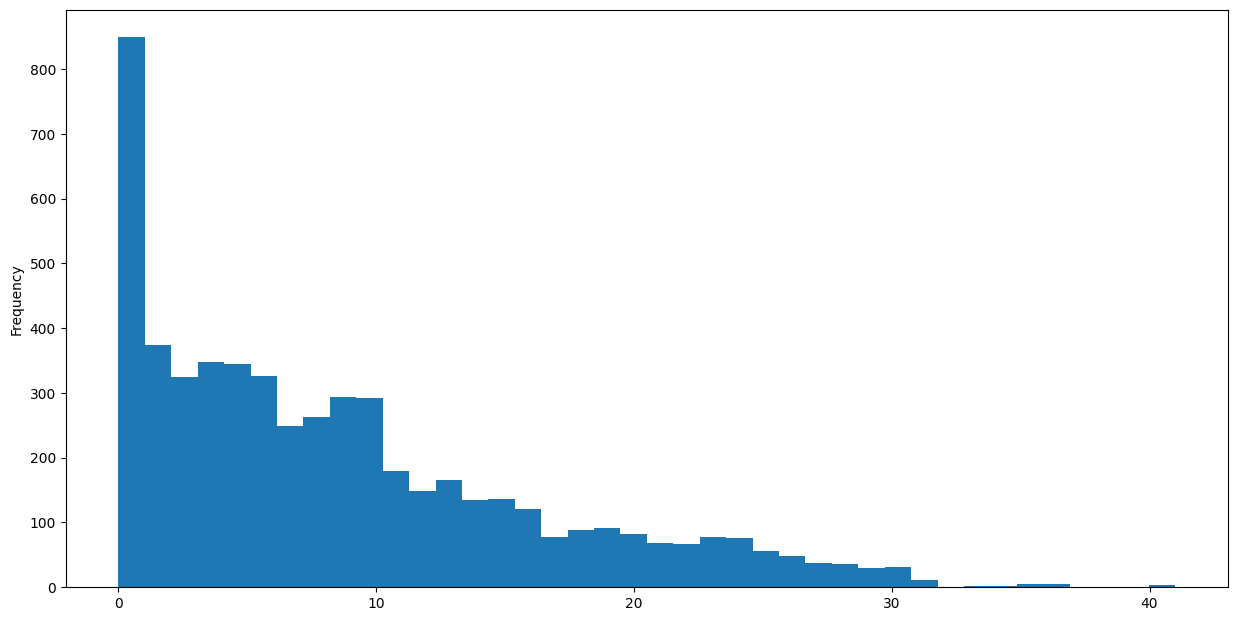

In [173]:
df["YOJ"].plot.hist(bins = 40,figsize=(15,7.5))

# This is very skewed. It would be better if we modify this variable to decrease the skewness.

In [174]:
df["DEROG"].value_counts()

# As can be observed, derogatory incidents were reported only in few cases.
# So, creating a binary variable with values 1 for atleast one derogatory incident and 0 for no such report may be useful.

0.0     4527
1.0      435
2.0      160
3.0       58
4.0       23
5.0       15
6.0       15
7.0        8
8.0        6
9.0        3
10.0       2
Name: DEROG, dtype: int64

In [175]:
df["DELINQ"].value_counts()

# Most of them are zero.
# Same as in above case creating a binary variable would be useful.

0.0     4179
1.0      654
2.0      250
3.0      129
4.0       78
5.0       38
6.0       27
7.0       13
8.0        5
10.0       2
11.0       2
15.0       1
12.0       1
13.0       1
Name: DELINQ, dtype: int64

In [176]:
df["NINQ"].value_counts()

# The counts are distributed mostly among first five values.

0.0     2531
1.0     1339
2.0      780
3.0      392
4.0      156
5.0       75
6.0       56
7.0       44
10.0      28
8.0       22
9.0       11
11.0      10
12.0       2
13.0       2
14.0       1
17.0       1
Name: NINQ, dtype: int64

# 2. Imputing the input variables

In [177]:
# Counting the number of cases with NaN

df.isnull().sum()

BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

In [178]:
# Nominal features
# Replacement using majority class
# Majority class in case of REASON varibale is 'DebtCon'.
# Majority class in case of JOB variable is 'Other'.

df["REASON"].fillna(value = "DebtCon",inplace = True)
df["JOB"].fillna(value = "Other",inplace = True)

In [179]:
df["DEROG"].fillna(value=0,inplace=True)
df["DELINQ"].fillna(value=0,inplace=True)

In [180]:
# Numeric features
# Replacement using mean of each class

df.fillna(value=df.mean(),inplace=True)

<ipython-input-180-720b10688736>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.fillna(value=df.mean(),inplace=True)


In [181]:
# Checking if there is anything left out

df.isnull().sum()

# As we can see, all missing values are filled.

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

In [182]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0000,39025.000000,HomeImp,Other,10.500000,0.0,0.0,94.366667,1.000000,9.000000,33.779915
1,1,1300,70053.0000,68400.000000,HomeImp,Other,7.000000,0.0,2.0,121.833333,0.000000,14.000000,33.779915
2,1,1500,13500.0000,16700.000000,HomeImp,Other,4.000000,0.0,0.0,149.466667,1.000000,10.000000,33.779915
3,1,1500,73760.8172,101776.048741,DebtCon,Other,8.922268,0.0,0.0,179.766275,1.186055,21.296096,33.779915
4,0,1700,97800.0000,112000.000000,HomeImp,Office,3.000000,0.0,0.0,93.333333,0.000000,14.000000,33.779915


# 3. Applying the models on the data after imputation


In [183]:
# Importing the required modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Removing the features BAD, JOB, REASON from the input features set
x_basic = df.drop(columns=["BAD","JOB","REASON"])
y = df["BAD"]

# Spliting the data into test and train sets
x_basic_tr,x_basic_te,y_tr,y_te = train_test_split(x_basic,y,test_size =.33,random_state=1)
logreg_basic = LogisticRegression()

# Training the basic logistic regression model with training set
logreg_basic.fit(x_basic_tr,y_tr)

# Printing the coefficients
print("intercept ")
print(logreg_basic.intercept_)
print("")
print("coefficients ")
print(logreg_basic.coef_)

# Predicting the output of the test cases using the algorithm created above
y_pre = logreg_basic.predict(x_basic_te)

# Validating the algorithm using various performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("")
a1 = accuracy_score(y_te,y_pre)
f1 = f1_score(y_te, y_pre, average="macro")
p1 = precision_score(y_te, y_pre, average="macro")
r1 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a1)
print("f1 score : ",f1)
print("precision score : ",p1)
print("recall score : ",r1)

intercept 
[-1.6e-05]

coefficients 
[[-1.75e-05 -4.04e-06  2.42e-06 -2.45e-04  6.35e-05  9.46e-05 -6.12e-03
   7.00e-05 -2.10e-04 -1.50e-04]]

accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [184]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.set_cmap('Greens')

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


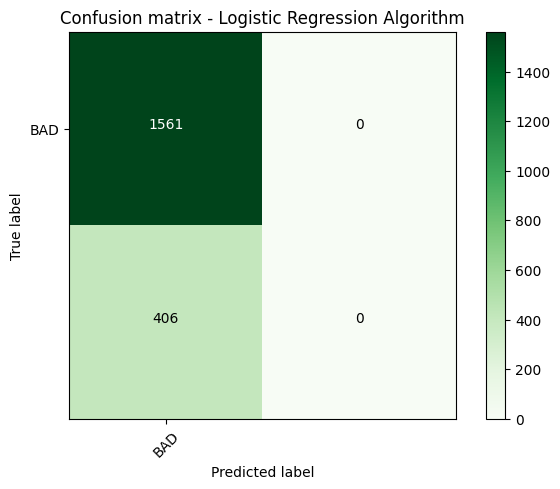

In [185]:
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix - Logistic Regression Algorithm')

plt.show()

accuracy score :  0.871377732587697
f1 score :  0.7975172363284231
precision score :  0.8076912079816739
recall score :  0.7886578011442709
Confusion matrix, without normalization
[[1451  110]
 [ 143  263]]


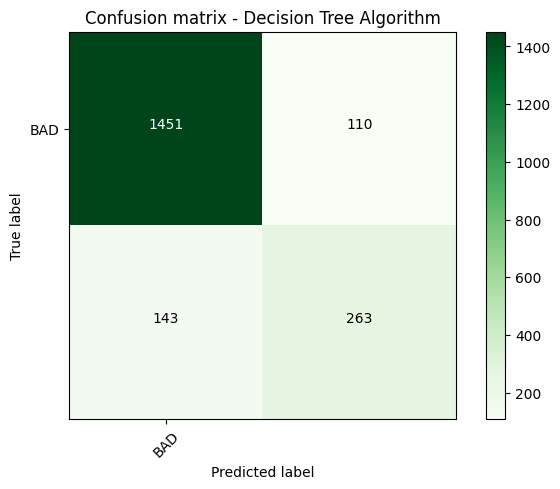

In [186]:
# Importing the required modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

dectree_basic = DecisionTreeClassifier()
dectree_basic.max_depth = 100  # Setting maximum number of layers to 101

# Training the basic Decision Tree model with training set
dectree_basic.fit(x_basic_tr,y_tr)

# Predicting the output of the test cases using the algorithm created above
y_pre = dectree_basic.predict(x_basic_te)

# Validating the algorithm using various Performance metrics

a2 = accuracy_score(y_te,y_pre)
f2 = f1_score(y_te, y_pre, average="macro")
p2 = precision_score(y_te, y_pre, average="macro")
r2 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a2)
print("f1 score : ",f2)
print("precision score : ",p2)
print("recall score : ",r2)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
                      title='Confusion matrix - Decision Tree Algorithm')

plt.show()

# 4. Feature transformation


In [187]:
# Capping off the features CLAGE(values >= 600 to 600) , VALUE(values>=400000 to 400000) , MORTDUE(values>=300000 to 300000) and DEBTINC(values >=100 to 100)

df.loc[df["CLAGE"]>=600,"CLAGE"] = 600
df.loc[df["VALUE"]>=400000,"VALUE"] = 400000
df.loc[df["MORTDUE"]>=300000,"MORTDUE"] = 300000
df.loc[df["DEBTINC"]>=100,"DEBTINC"] = 100

In [188]:
# Creating new binary vaiables B_DEROG,B_DELINQ from DEROG,DELINQ

df["B_DEROG"] = (df["DEROG"]>=1)*1
df["B_DELINQ"] = (df["DELINQ"]>=1)*1

In [189]:
df["JOB"].unique()

array(['Other', 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'], dtype=object)

In [190]:
# We need to convert the nominal features JOB and REASON into usable form and remove them from the data table.

df["REASON_1"] = (df["REASON"] == "HomeImp")*1
df["REASON_2"] = (df["REASON"] != "HomeImp")*1
df["JOB_1"] = (df["JOB"]=="Other")*1
df["JOB_2"] = (df["JOB"]=="Office")*1
df["JOB_3"] = (df["JOB"]=="Sales")*1
df["JOB_4"] = (df["JOB"]=="Mgr")*1
df["JOB_5"] = (df["JOB"]=="ProfExe")*1
df["JOB_6"] = (df["JOB"]=="Self")*1
df.drop(["JOB","REASON"],axis = 1,inplace = True)

# The above assignment creates new features for each JOB and each REASON.

In [191]:
# We need to decrease the skewness of the feature YOJ,For that we can apply log of YOJ but since some of them are 0, we will use log(YOJ+constant)

df["YOJ"] = df["YOJ"].apply(lambda t : np.log(t+1))

In [192]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,...,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,...,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,...,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,...,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,...,0,0,1,0,0,1,0,0,0,0


# 5. Feature selection


In [193]:
# Finding correlation between all the features and the target feature "BAD"

df.corr(method='pearson')

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
BAD,1.000000,-0.075099,-0.049420,-0.043711,-0.053066,0.269921,0.346503,-0.173412,0.168851,-0.004067,...,0.261216,0.308153,0.037517,-0.037517,0.037949,-0.073613,0.050934,0.032583,-0.043561,0.046245
LOAN,-0.075099,1.000000,0.214803,0.338749,0.102458,0.006996,-0.028869,0.088875,0.043160,0.071804,...,0.009079,-0.030646,-0.151477,0.151477,-0.058067,-0.018060,-0.044993,0.018769,0.017488,0.158452
MORTDUE,-0.049420,0.214803,1.000000,0.816001,-0.052771,-0.046526,0.002095,0.132928,0.026853,0.314779,...,-0.041471,-0.014568,-0.026941,0.026941,-0.259602,-0.066813,0.026023,0.076687,0.256575,0.107944
VALUE,-0.043711,0.338749,0.816001,1.000000,0.023878,-0.041263,-0.000578,0.178638,-0.004635,0.283654,...,-0.040482,-0.034988,-0.012308,0.012308,-0.288132,-0.058463,0.018250,0.051960,0.282653,0.163060
YOJ,-0.053066,0.102458,-0.052771,0.023878,1.000000,-0.050552,0.023185,0.145111,-0.052621,0.042928,...,-0.058295,0.023075,0.060306,-0.060306,0.023324,-0.066539,-0.041243,0.029926,0.024664,-0.010586
DEROG,0.269921,0.006996,-0.046526,-0.041263,-0.050552,1.000000,0.171286,-0.081231,0.146700,0.050727,...,0.755021,0.171622,-0.008406,0.008406,0.034537,-0.049223,0.030659,0.031342,-0.033939,0.000836
DELINQ,0.346503,-0.028869,0.002095,-0.000578,0.023185,0.171286,1.000000,0.026713,0.057212,0.159378,...,0.188767,0.748356,0.004024,-0.004024,-0.044718,0.005268,-0.016502,0.059350,-0.002911,0.021694
CLAGE,-0.173412,0.088875,0.132928,0.178638,0.145111,-0.081231,0.026713,1.000000,-0.110857,0.242213,...,-0.083332,0.007707,0.050670,-0.050670,-0.080490,0.000032,0.026502,-0.022948,0.112309,-0.010872
NINQ,0.168851,0.043160,0.026853,-0.004635,-0.052621,0.146700,0.057212,-0.110857,1.000000,0.085148,...,0.152237,0.059767,-0.115992,0.115992,0.054470,-0.063735,-0.035677,0.069826,-0.061553,0.016229
CLNO,-0.004067,0.071804,0.314779,0.283654,0.042928,0.050727,0.159378,0.242213,0.085148,1.000000,...,0.035880,0.154674,-0.107224,0.107224,-0.197815,-0.004549,0.049185,0.060210,0.165109,0.031325


In [194]:
# Gathering the 2 feature sets with high pearson correlation value, one with 7 and other with 10 features in it

feat1=["DEROG","DELINQ","CLAGE","NINQ","DEBTINC","YOJ","LOAN"]
#feat2=["DEROG","DELINQ","CLAGE","NINQ","DEBTINC","LOAN","JOB_2","YOJ","JOB_3","MORTDUE"]

In [195]:
# Now that we got the features with high correlation with the BAD feature, we will run the classification algorithms and compare them

accuracy score :  0.824097610574479
f1 score :  0.6408659549228944
precision score :  0.763878859958374
recall score :  0.6176301663389958
Confusion matrix, without normalization
[[1513   48]
 [ 298  108]]


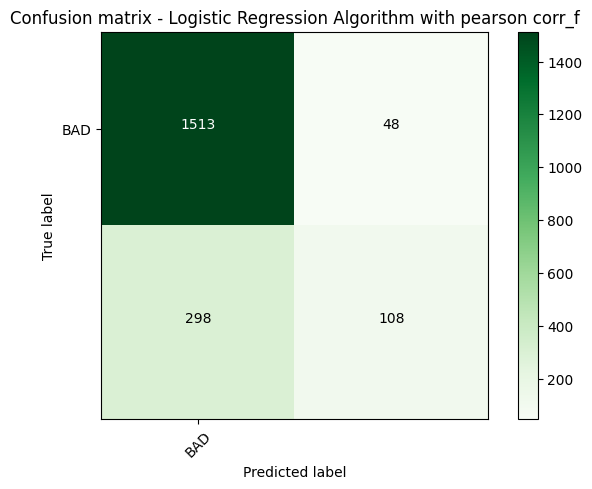

In [196]:
# Logistic Regression using above feature set 1

x = df[feat1]
y = df["BAD"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size = 0.33,random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
y_pre = logreg.predict(x_te)
a3 = accuracy_score(y_te,y_pre)
f3 = f1_score(y_te, y_pre, average="macro")
p3 = precision_score(y_te, y_pre, average="macro")
r3 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a3)
print("f1 score : ",f3)
print("precision score : ",p3)
print("recall score : ",r3)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Logistic Regression Algorithm with pearson corr_f')

plt.show()

accuracy score :  0.8525673614641586
f1 score :  0.7741593977056055
precision score :  0.7751744472525551
recall score :  0.7731615454284388

Confusion matrix, without normalization
[[1418  143]
 [ 147  259]]


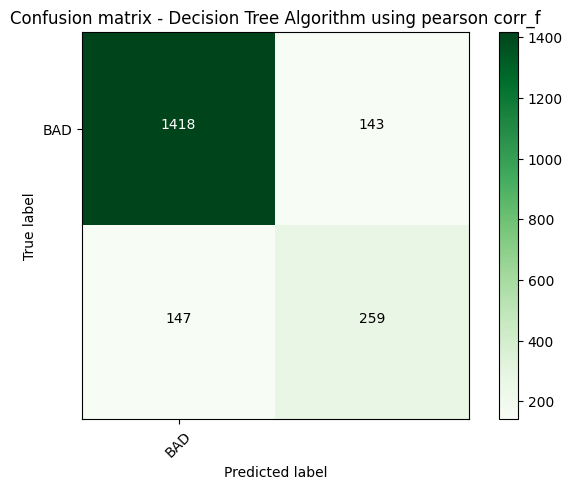

In [197]:
# Decision Tree classifier using feat1

clf_tree=DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr,y_tr)
y_pre = clf_tree.predict(x_te)
a4 = accuracy_score(y_te,y_pre)
f4 = f1_score(y_te, y_pre, average="macro")
p4 = precision_score(y_te, y_pre, average="macro")
r4 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a4)
print("f1 score : ",f4)
print("precision score : ",p4)
print("recall score : ",r4)
print("")
# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Decision Tree Algorithm using pearson corr_f')

plt.show()

In [198]:
# Using chi2 test for feature selection

In [199]:
# Finding the best 10 features using chi2 test

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
df_new = pd.DataFrame(SelectKBest(chi2, k=10).fit_transform(df.drop(["BAD"],axis = 1),df["BAD"]))

In [200]:
# dataframe containing the selected features

df_new.head()

,0,1,2,3,4,5,6,7,8,9
0,1100.0,25860.0000,39025.000000,0.0,0.0,94.366667,1.000000,33.779915,0.0,0.0
1,1300.0,70053.0000,68400.000000,0.0,2.0,121.833333,0.000000,33.779915,0.0,1.0
2,1500.0,13500.0000,16700.000000,0.0,0.0,149.466667,1.000000,33.779915,0.0,0.0
3,1500.0,73760.8172,101776.048741,0.0,0.0,179.766275,1.186055,33.779915,0.0,0.0
4,1700.0,97800.0000,112000.000000,0.0,0.0,93.333333,0.000000,33.779915,0.0,0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy score :  0.7935943060498221
f1 score :  0.44246031746031744
precision score :  0.39679715302491103
recall score :  0.5
Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]


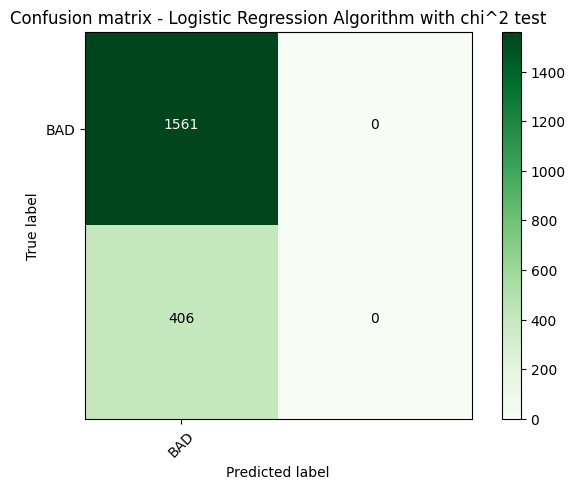

In [201]:
# Running the logistic regression algorithm using the features selected from chi2 test

x = df_new
y = df["BAD"]
x_tr,x_te,y_tr,y_te = train_test_split(x,y,test_size = .33,random_state=1)
logreg = LogisticRegression()
logreg.fit(x_tr,y_tr)
y_pre = logreg.predict(x_te)
y_pre = logreg.predict(x_te)
a5 = accuracy_score(y_te,y_pre)
f5 = f1_score(y_te, y_pre, average="macro")
p5 = precision_score(y_te, y_pre, average="macro")
r5 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a5)
print("f1 score : ",f5)
print("precision score : ",p5)
print("recall score : ",r5)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
 title='Confusion matrix - Logistic Regression Algorithm with chi^2 test')

plt.show()

accuracy score :  0.8576512455516014
f1 score :  0.7790915946028334
precision score :  0.7840038064023296
recall score :  0.7745421811835914
Confusion matrix, without normalization
[[1430  131]
 [ 149  257]]


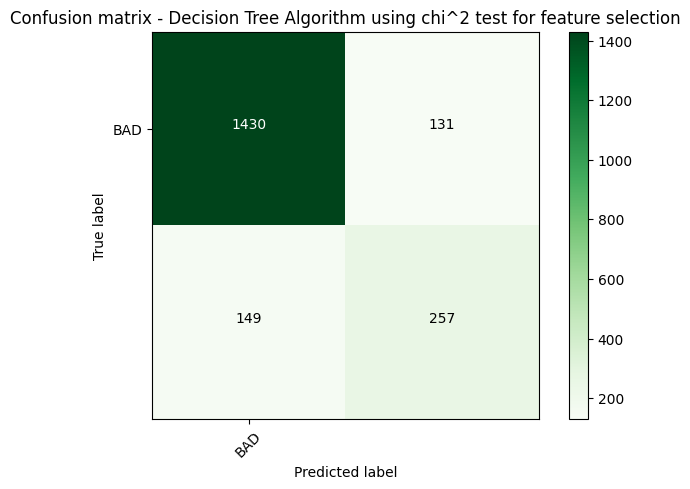

In [202]:
# Decision Tree classifier using features from chi2 test

clf_tree=DecisionTreeClassifier()
clf_tree.max_depth = 100
clf_tree.fit(x_tr,y_tr)
y_pre = clf_tree.predict(x_te)
a6 = accuracy_score(y_te,y_pre)
f6 = f1_score(y_te, y_pre, average="macro")
p6 = precision_score(y_te, y_pre, average="macro")
r6 = recall_score(y_te, y_pre, average="macro")
print("accuracy score : ",a6)
print("f1 score : ",f6)
print("precision score : ",p6)
print("recall score : ",r6)

# Computing Confusion matrix for the above algorithm

cnf_matrix = confusion_matrix(y_te, y_pre)
np.set_printoptions(precision=2)

# Plotting non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["BAD"],
title='Confusion matrix - Decision Tree Algorithm using chi^2 test for feature selection')

plt.show()

In [203]:
df.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,B_DEROG,B_DELINQ,REASON_1,REASON_2,JOB_1,JOB_2,JOB_3,JOB_4,JOB_5,JOB_6
0,1,1100,25860.0000,39025.000000,2.442347,0.0,0.0,94.366667,1.000000,9.000000,...,0,0,1,0,1,0,0,0,0,0
1,1,1300,70053.0000,68400.000000,2.079442,0.0,2.0,121.833333,0.000000,14.000000,...,0,1,1,0,1,0,0,0,0,0
2,1,1500,13500.0000,16700.000000,1.609438,0.0,0.0,149.466667,1.000000,10.000000,...,0,0,1,0,1,0,0,0,0,0
3,1,1500,73760.8172,101776.048741,2.294782,0.0,0.0,179.766275,1.186055,21.296096,...,0,0,0,1,1,0,0,0,0,0
4,0,1700,97800.0000,112000.000000,1.386294,0.0,0.0,93.333333,0.000000,14.000000,...,0,0,1,0,0,1,0,0,0,0


# 6. Comparing all the models


In [204]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree','Logistic Regression', 'Decision Tree','Logistic Regression', 'Decision Tree'],
    'Feature Selection Method' : ['None','None','Pearson corr_fact','Pearson corr_fact','chi2 test','chi2 test'],
    'Accuracy Score': [a1,a2,a3,a4,a5,a6],
    'Recall Score' : [r1,r2,r3,r4,r5,r6],
    'F1 Score' : [f1,f2,f3,f4,f5,f6],
    'Precision Score' : [p1,p2,p3,p4,p5,p6]
})

In [205]:
models

,Model,Feature Selection Method,Accuracy Score,Recall Score,F1 Score,Precision Score
0,Logistic Regression,None,0.793594,0.500000,0.442460,0.396797
1,Decision Tree,None,0.871378,0.788658,0.797517,0.807691
2,Logistic Regression,Pearson corr_fact,0.824098,0.617630,0.640866,0.763879
3,Decision Tree,Pearson corr_fact,0.852567,0.773162,0.774159,0.775174
4,Logistic Regression,chi2 test,0.793594,0.500000,0.442460,0.396797
5,Decision Tree,chi2 test,0.857651,0.774542,0.779092,0.784004


In [206]:
pd.pivot_table(models,index = ["Feature Selection Method","Model"])

Accuracy Score  F1 Score  \
Feature Selection Method Model                                           
None                     Decision Tree              0.871378  0.797517   
                         Logistic Regression        0.793594  0.442460   
Pearson corr_fact        Decision Tree              0.852567  0.774159   
                         Logistic Regression        0.824098  0.640866   
chi2 test                Decision Tree              0.857651  0.779092   
                         Logistic Regression        0.793594  0.442460   

                                              Precision Score  Recall Score  
Feature Selection Method Model                                               
None                     Decision Tree               0.807691      0.788658  
                         Logistic Regression         0.396797      0.500000  
Pearson corr_fact        Decision Tree               0.775174      0.773162  
                         Logistic Regression         0.763879      0.617630  
chi2 test                Decision Tree               0.784004      0.774542  
                         Logistic Regression         0.396797      0.500000

# 7. Changing the threshold and observing the performance

Recall metric in the testing dataset:  0.9384236453201971
Accuracy score for the testing dataset:  0.3014743263853584
Confusion matrix, without normalization
[[ 212 1349]
 [  25  381]]

Recall metric in the testing dataset:  0.6133004926108374
Accuracy score for the testing dataset:  0.6024402643619725
Confusion matrix, without normalization
[[936 625]
 [157 249]]

Recall metric in the testing dataset:  0.22660098522167488
Accuracy score for the testing dataset:  0.7793594306049823
Confusion matrix, without normalization
[[1441  120]
 [ 314   92]]

Recall metric in the testing dataset:  0.007389162561576354
Accuracy score for the testing dataset:  0.7915607524148449
Confusion matrix, without normalization
[[1554    7]
 [ 403    3]]

Recall metric in the testing dataset:  0.0
Accuracy score for the testing dataset:  0.7935943060498221
Confusion matrix, without normalization
[[1561    0]
 [ 406    0]]

Recall metric in the testing dataset:  0.0
Accuracy score for the testing dataset:  0.

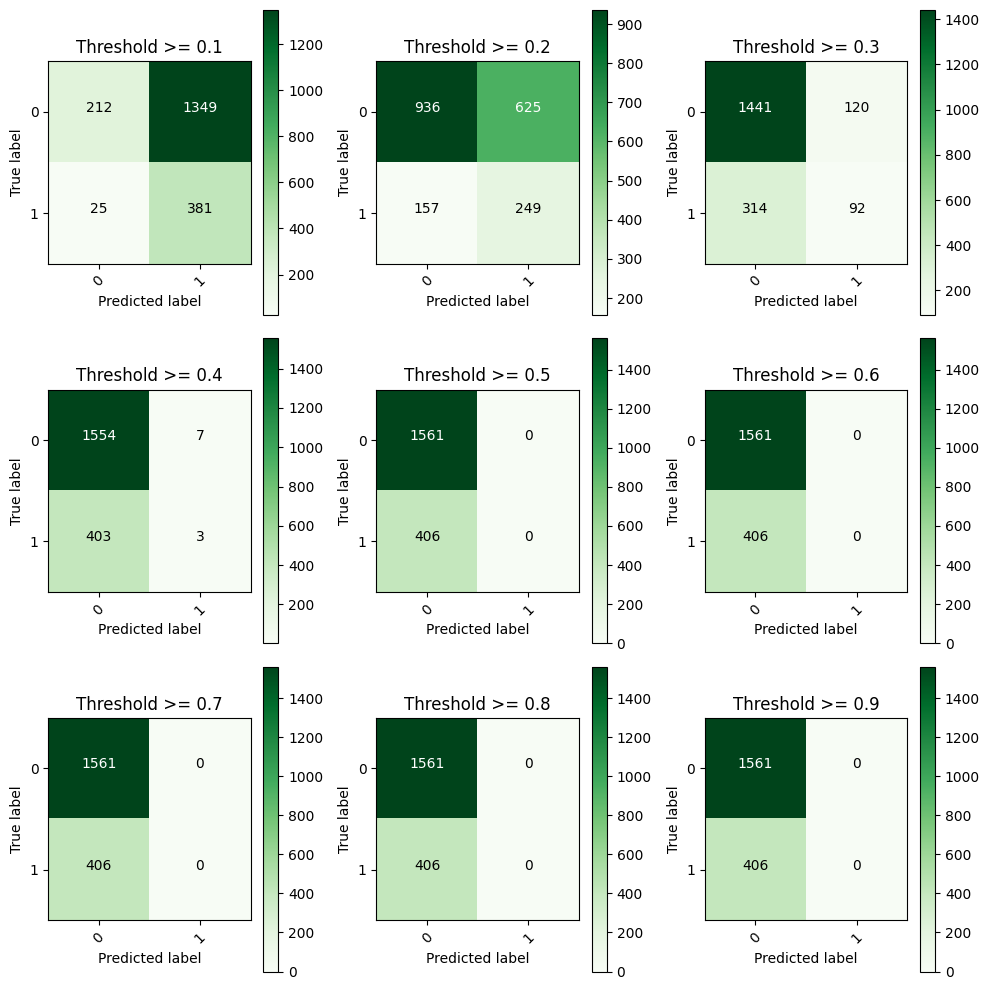

In [207]:
lr = LogisticRegression()
lr.fit(x_tr,y_tr)
y_pred_proba = lr.predict_proba(x_te)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:,1] >= i

    plt.subplot(3,3,j)
    j += 1

    # Computing confusion matrix
    cnf_matrix = confusion_matrix(y_te,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    rec1 = recall_score(y_te, y_test_predictions_high_recall)
    acc= 1.0*(cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[1,0]+cnf_matrix[1,1]+cnf_matrix[0,1])
    print("Recall metric in the testing dataset: ",rec1)
    print("Accuracy score for the testing dataset: ",acc)

    # Plotting non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)
    print("")

In [208]:
# As can be seen, all thresholds greater than 0.5 yield the same results. Hence, the default value of 0.5 is generally used without altering.